# New Baseline Regression Models with Transformed Data

##### Modeling Step 2

### Notebook Summary:

#### Objective: create a new baseline model to predict AirBnB listing prices with the newly created features

* We now operate on 138 features resulting from data extraction from existing features and additional ETL efforts with files originating from the County of San Diego website 
* We create a new Linear Regression model and this time obtain accuracy of approximately 80% on the test set. Training and Validation accuracies are a bit higher
* We then compare results with Decisition Tree, Support Vector, and K-Neighbors Regressions For each, we tune parameters as necessary to minimize validation RMSE. Model results are generally good, but not as good as Linear Regression results
* We test the same model on both normalized and scaled versions of the same data

#### Conclusions: 
* This model seems to offer a satisfactory bias/variance trade off (See plots)
* Geographic features (distance to ocean, number of recreation structures in the vicinity, parks, etc.) provide significant improvement to accuracy. Other features related to the amenities offered, host attributes and listing description text topics also play a significant role
* As our new baseline model, we pick Linear Regression

#### Next Steps: 
###### In the poly_regressions notebook we try additional techniques to further improve model accuracy including adding 200 ca. new features created from ratios of certain existing features, interaction and polynomial transformations, and feature selection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm
%matplotlib inline

In [3]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from sklearn.feature_selection import RFE, f_regression, RFECV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [4]:
import sys
sys.path.append('./../lib')
from airbnb_modeling import detect_feature_importance, scale_data, normalize_data, eval_metrics, plot_residuals, plot_predictions, rank_to_dict
from parse_methods import parse_columns
from airbnb_modeling import detect_interactions, add_interactions, map_variable, plot_rmse_instances,plot_rmse_features, plot_accuracy_instances
from model_visualizations import plot_learning_curve

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
listings = pd.read_csv('../Datasources/listings_augmented/listings_augmented_2018-05-31_V3.csv',low_memory=False)
listings = listings.drop(listings.index[4323:4325])
listings.index = [i for i in range(len(listings))]

In [6]:
#Excluded variables from the featuresExploration notebook
%store -r excluded

In [7]:
cols = [i for i in listings.columns if i not in excluded]
X = listings[cols]

In [8]:
X[X.columns[X.isnull().any()]].isnull().sum()

space        1275
bathrooms      10
bedrooms        3
beds            4
dtype: int64

In [9]:
X = X.fillna(X.mean())

In [10]:
X = parse_columns(X, ['has_Pets_Allowed','has_Wheelchair_Accessible','has_First_Aid_Kit',
'has_Cat(s)','has_24-Hour_Check-in','uses_jumio','description-Topic0','description-Topic1',
'description-Topic4','description-Topic5','description-Topic6','description-Topic10',
'description-Topic11','description-Topic12','description-Topic13','description-Topic15',
'description-Topic17','description-Topic18','description-Dominant_Topic'])

In [11]:
X = X[[i for i in X.columns if i not in X.filter(regex='enc').columns]]
donotscale = X.filter(regex='bin').columns
cols = [i for i in X.columns if i not in donotscale]

In [12]:
cols.remove('space')
cols.remove('amenity_level')
cols.remove('hol_skew_of_price')

In [13]:
helper_df = pd.DataFrame(preprocessing.normalize(X[cols]), columns = cols)

In [14]:
X_normed = helper_df.merge(X[donotscale], right_index=True, left_index=True)

Now adding new features by taking ratios between features 

In [15]:
other = ['calculated_host_listings_count','extra_people', 'minimum_nights', 'number_of_reviews']
candidates = list(X_normed.filter(regex='event').columns) \
+ list(X_normed.filter(regex='park').columns) + list(X_normed.filter(regex='ocean').columns)\
+ list(X_normed.filter(regex='ratio').columns) + other

In [16]:
import itertools
a = []
for subset in itertools.combinations(candidates, 2):
    a.append(subset)

In [17]:
new = [i for i in a if "bin" not in i[0] and "bin" not in i[1]]

In [18]:
X_ratios = X_normed.copy()
for i in new:
    name = str(i[0]) + '/' + str(i[1]) + '_ratio'
    X_ratios[name] = X_ratios[i[0]]/X_ratios[i[1]]

In [19]:
#Lots of nulls above so dropping columns that have more than 300 nulls and imputing the remaining ones
X_ratios = X_ratios.dropna(axis = 1,thresh = len(X_normed)-300)
X_ratios = X_ratios.replace([np.inf, -np.inf], np.nan)
X_ratios = X_ratios.fillna(X_ratios.mean())

In [20]:
y_normed = X_normed['price_y'].fillna(X_normed['price_y'].mean())
X_normed = X_normed[X_normed.columns.drop(X_normed[list(X_normed.filter(regex='price'))])]
X_ratios = X_ratios[X_ratios.columns.drop(X_ratios[list(X_ratios.filter(regex='price'))])]

In [21]:
#Checking that features are clean - output should be False - True
print np.any(np.isnan(X_normed))
print np.all(np.isfinite(X_normed))

False
True


Step1: Simple Model with Linear Regression

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_normed,y_normed, test_size=0.3, random_state=42)

In [23]:
print 'Final Number of Features Used: ', len(X_train.columns)

Final Number of Features Used:  138


In [24]:
lin_reg = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train, y_train)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
lin_reg_rmse_test = np.sqrt(mean_squared_error(y_test, lin_reg.predict(X_test)))
print 'Test RMSE for Initial Linear Regression: ', lin_reg_rmse_test

Test RMSE for Initial Linear Regression:  0.025984902976912066


In [26]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Using Cross Validation

In [27]:
scores_lin = cross_validate(lin_reg, X_train, y_train, cv=10, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [28]:
scores_tree = cross_validate(tree_reg, X_train, y_train, cv=10, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [29]:
print 'Evaluation Metrics for Linear Regression with CV: '
eval_metrics(scores_lin)
print '----'
print '----'
print 'Evaluation Metrics for Tree Regression with CV: '
eval_metrics(scores_tree)

Evaluation Metrics for Linear Regression with CV: 
Training R2 Mean:  0.8367261556254737
Validation R2 Mean:  0.8141108210063563
Validation R2 STdev:  0.02281127611849167
--
Training RMSE Mean:  0.02517032237136816
Validation RMSE Mean:  0.02671513027489586
Validation RMSE STdev:  6.635340961825122e-05
--
Training MAE Mean:  0.0195095861192613
Validation MAE Mean:  0.02054359368106534
Validation MAE STdev:  0.0009910646197029544
----
----
Evaluation Metrics for Tree Regression with CV: 
Training R2 Mean:  0.9999977308530943
Validation R2 Mean:  0.7279805707015593
Validation R2 STdev:  0.051243400957153386
--
Training RMSE Mean:  9.383340186128147e-05
Validation RMSE Mean:  0.03221793482785554
Validation RMSE STdev:  0.00013107106333642445
--
Training MAE Mean:  4.024771189958336e-05
Validation MAE Mean:  0.022801312753663563
Validation MAE STdev:  0.0013020193606534181


<module 'matplotlib.pyplot' from '/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

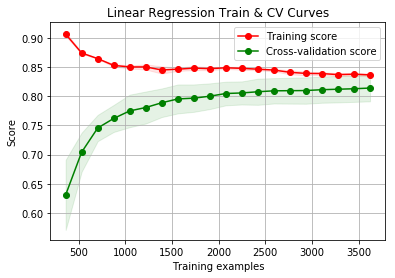

In [30]:
plot_learning_curve(lin_reg, "Linear Regression Train & CV Curves", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

<module 'matplotlib.pyplot' from '/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

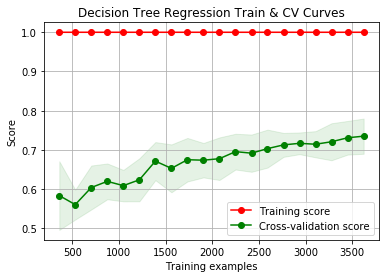

In [31]:
plot_learning_curve(tree_reg, "Decision Tree Regression Train & CV Curves", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

Using Nested Cross Validation with GridSearch CV - Testing Decision Tree, Suppor Vector, KNN Regressions

In [32]:
param_grid = {'max_depth': np.arange(3, 10)}

In [33]:
gs = GridSearchCV(tree_reg, param_grid, cv=4, scoring='neg_mean_squared_error')

In [34]:
gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [35]:
scores_dec_tree = cross_validate(gs, X_train, y_train, cv=10, return_train_score=True,
                         scoring='neg_mean_squared_error')

In [36]:
gs_results_dtree = gs.cv_results_
print 'Avg Mean Train Score: ', np.sqrt(-gs_results_dtree['mean_train_score'].mean())
print 'Avg Mean Val Score: ', np.sqrt(-gs_results_dtree['mean_test_score'].mean())

Avg Mean Train Score:  0.02568916888045518
Avg Mean Val Score:  0.03209740077985542


/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [37]:
best_model_dtree = gs.best_estimator_

<module 'matplotlib.pyplot' from '/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

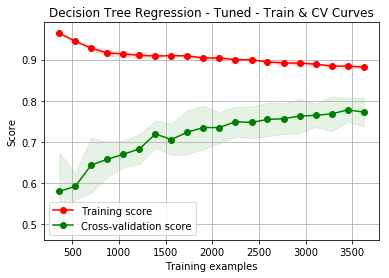

In [38]:
plot_learning_curve(best_model_dtree, "Decision Tree Regression - Tuned - Train & CV Curves", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

SVR

In [39]:
sv_reg = SVR()

In [40]:
Cs = np.logspace(-0.1, 10, 50)
param_grid = [
    {'C':Cs, 'epsilon':[i for i in range(1,20,1)], 'kernel':['linear'],
    'degree':[2,3,4]},]

In [41]:
gs = GridSearchCV(sv_reg, param_grid, cv=4, scoring='neg_mean_squared_error')

In [42]:
gs.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'epsilon': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'C': array([7.94328e-01, 1.27680e+00, 2.05232e+00, 3.29889e+00, 5.30261e+00,
       8.52339e+00, 1.37004e+01, 2.20220e+01, 3.53981e+01, 5.68987e+01,
       9.14586e+01, 1.47010e+02, 2.36303e+02, 3.79832e+02,...9, 2.40787e+09, 3.87039e+09, 6.22125e+09, 1.00000e+10]), 'degree': [2, 3, 4], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [43]:
scores_sv_reg = cross_validate(gs, X_train, y_train, cv=10, return_train_score=True,
                         scoring='neg_mean_squared_error')

In [44]:
gs_results_svreg = gs.cv_results_
print 'Avg Mean Train Score: ', np.sqrt(-gs_results_svreg['mean_train_score'].mean())
print 'Avg Mean Val Score: ', np.sqrt(-gs_results_svreg['mean_test_score'].mean())

Avg Mean Train Score:  0.08451085066435074
Avg Mean Val Score:  0.08449926935820785


In [45]:
best_model_svr = gs.best_estimator_

<module 'matplotlib.pyplot' from '/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

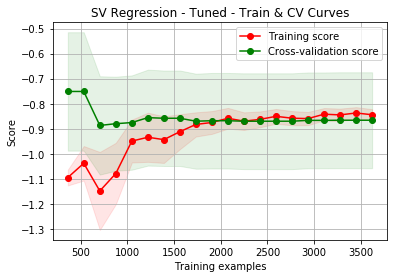

In [46]:
plot_learning_curve(best_model_svr, "SV Regression - Tuned - Train & CV Curves", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

KNR

In [47]:
neigh_reg = KNeighborsRegressor()

In [48]:
param_grid = [
    {'n_neighbors':[i for i in range(2,8)], 
     'metric':['euclidean']},]
#euclidean: sqrt(sum((x - y)^2)) 
#minkowski: sum(|x - y|^p)^(1/p)

In [49]:
gs = GridSearchCV(neigh_reg, param_grid, cv=3, scoring='neg_mean_squared_error')

In [50]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7], 'metric': ['euclidean']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [51]:
scores_neigh_reg = cross_validate(gs, X_train, y_train, cv=3, return_train_score=True,
                         scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error'))

In [52]:
gs_results_nn = gs.cv_results_
mean_train_score_nnreg = np.sqrt(-gs_results_nn['mean_train_score'].mean())
mean_val_score = np.sqrt(-gs_results_nn['mean_test_score'].mean())
print 'Avg Mean Train Score: ', mean_train_score_nnreg
print 'Avg Mean Val Score: ', mean_val_score

Avg Mean Train Score:  0.022401750872305195
Avg Mean Val Score:  0.030087933275903606


In [53]:
best_model_kneigh = gs.best_estimator_

In [ ]:
plot_learning_curve(best_model_kneigh, "KN Regression - Tuned - Train & CV Curves", X_train, y_train, ylim=None, cv=10,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20))

Now we evaluate the predictions on the test set

In [ ]:
test_predictions_lin_reg = lin_reg.predict(X_test)
test_predictions_tree_reg = best_model_dtree.predict(X_test)
test_predictions_best_model_svr = best_model_svr.predict(X_test)
test_predictions_best_model_kneigh = best_model_kneigh.predict(X_test)

In [ ]:
print 'Evaluation Metrics for Decision Tree Regression'
print 'Test R2: ',r2_score(y_test, test_predictions_lin_reg)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_lin_reg))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_lin_reg)
map_variable(y_test-test_predictions_lin_reg, listings)

In [ ]:
from yellowbrick.regressor import ResidualsPlot

In [ ]:
tree_reg_pred_cv = cross_val_predict(tree_reg, X_train, y_train, cv=10)

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(tree_reg_pred_cv, tree_reg_pred_cv-y_train, 
            c='steelblue', marker='o', edgecolor='white',
           label='CV Train Data')
plt.scatter(test_predictions_tree_reg, test_predictions_tree_reg-y_test, 
            c='limegreen', marker='x', edgecolor='red',
           label='Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, color='black', xmin=0, xmax=.35, lw=3)
plt.title('Predicted Values vs Residuals - Decision Tree Regression')
plt.show()

In [ ]:
print 'Evaluation Metrics for Support Vector Regression'
print 'Test R2: ',r2_score(y_test, test_predictions_best_model_svr)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_best_model_svr))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_best_model_svr)
map_variable(y_test-test_predictions_best_model_svr, listings)

In [ ]:
reg_svr_best_model_pred_cv = cross_val_predict(best_model_svr, X_train, y_train, cv=10)

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(reg_svr_best_model_pred_cv, reg_svr_best_model_pred_cv-y_train, 
            c='steelblue', marker='o', edgecolor='white',
           label='CV Train Data')
plt.scatter(test_predictions_best_model_svr, test_predictions_best_model_svr-y_test, 
            c='limegreen', marker='x', edgecolor='red',
           label='Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, color='black', xmin=0, xmax=.35, lw=3)
plt.title('Predicted Values vs Residuals - Tuned Support Vector Regression')
plt.show()

In [ ]:
print 'Evaluation Metrics for K Nearest Neighbors Regression'
print 'Test R2: ',r2_score(y_test, test_predictions_best_model_kneigh)
print 'Test RMSE: ',np.sqrt(mean_squared_error(y_test, test_predictions_best_model_kneigh))
print 'Test MAE: ',mean_absolute_error(y_test, test_predictions_best_model_kneigh)
map_variable(y_test-test_predictions_best_model_kneigh, listings)

In [ ]:
kneigh_best_model_pred_cv = cross_val_predict(best_model_kneigh, X_train, y_train, cv=10)

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(kneigh_best_model_pred_cv, kneigh_best_model_pred_cv-y_train, 
            c='steelblue', marker='o', edgecolor='white',
           label='CV Train Data')
plt.scatter(test_predictions_best_model_kneigh, test_predictions_best_model_kneigh-y_test, 
            c='limegreen', marker='x', edgecolor='red',
           label='Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
plt.hlines(y=0, color='black', xmin=-.05, xmax=.35, lw=3)
plt.title('Predicted Values vs Residuals - Tuned K Neighbor Regression')
plt.show()

In [ ]:
sv_reg

In [ ]:
#Storing Feature Importances for Linear Regression

In [ ]:
ranks = {}

In [ ]:
ranks["Linear_Reg"] = rank_to_dict(np.abs(lin_reg.coef_), X_normed.columns)
ranks["DT_Reg"] = rank_to_dict(np.abs(best_model_dtree.feature_importances_), X_normed.columns)
#ranks["SV_Reg"] = rank_to_dict(np.abs(best_model_svr.coef_), X_normed.columns)
#Nothing for KNN

In [ ]:
%store ranks

In [ ]:
%store scores_lin
%store scores_tree
%store scores_sv_reg
%store scores_neigh_reg

In [ ]:
%store best_model_svr 
%store best_model_kneigh
%store best_model_dtree
%store lin_reg

In [ ]:
%store X_ratios
%store X_normed
%store X_test
%store y_normed
%store y_test
%store listings

In [ ]:
%store scores_lin
%store scores_tree
%store gs_results_svreg
%store gs_results_nn
%store lin_reg_rmse_test

In [ ]:
%store test_predictions_lin_reg
%store test_predictions_tree_reg
%store test_predictions_best_model_svr
%store test_predictions_best_model_kneigh